In [1]:
%%bash
c++ -g -o _residual.dylib residual.cpp -std=c++14 -fPIC -shared \
    -L$HOME/miniconda3/envs/iebeam/lib -I$HOME/miniconda3/envs/iebeam/include;
    
install_name_tool -add_rpath $HOME/miniconda3/envs/iebeam/lib _residual.dylib

In [2]:
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import cffi
from scipy.special import legendre
from scipy.optimize import newton_krylov, fsolve, anderson


ffi = cffi.FFI()


ffi.cdef("""
            void computeResidual(const int p, const int beam_type_flag, const double youngs_mod, 
                   const double area, const double moment_of_inertia, 
                   const int int_rule, const double* int_points, const double* int_wts, 
                   const int num_elements, const int num_of_nodes_per_element, 
                   const int num_dofs_per_node, const int num_dof, const double* nodes, 
                   const double* unknowns, double* residual);
                        
            void evaluate_u1(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* u1);
                       
            void evaluate_u2(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* u2);
                
            void evaluate_u2_IGA(const int p, int num_of_eval_pts, const int length, const int num_knots, 
                       const double* knot_vector, const double* solution, 
                       double* x, double* u2);
                       
            void evaluate_u1_IGA(const int p, const int num_of_eval_pts, const int length, const int num_knots, 
                       const double* knot_vector, const double* solution, 
                       double* x, double* u1);
                       
            void evaluate_lambda_IGA(const int p, const int num_of_eval_pts, const int length, const int num_knots, 
                       const double* knot_vector, const double* solution, 
                       double* x, double* lambda);
                   
            void evaluate_lambda(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* lambda);
                   
            void evaluate_constraint(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* constraint);  
                   
            void evaluate_constraint_IGA(const int p, const int num_of_eval_pts, const double length, const int num_knots, 
                       const double* knot_vector, const double* solution, 
                       double* x, double* constraint);
                   
            void bspline(const int p, const int num_of_eval_pts, const double length, const int num_knots, 
                   const double* knot_vector, double* x, double* spline);
            
            void computeIGAResidual(const int p, const bool constraint_flag, const double youngs_mod, const double area, const double moment_of_inertia, 
                        const double P1_location, const double P2_location, const double P1, const double P2,
                        const int int_rule, const double* int_points, const double* int_wts, 
                        const int num_knots, const double* knot_vector,
                        const double* unknowns, double* residual);
                        
            void computeIGAResidual2(const int p, const bool constraint_flag, const double youngs_mod, const double area, const double moment_of_inertia, 
                        const double P1_location, const double P2_location, const double P1, const double P2,
                        const int int_rule, const double* int_points, const double* int_wts, 
                        const int num_knots, const double* knot_vector,
                        const double* unknowns, double* residual);
            """)

res = ffi.dlopen("_residual.dylib")

In [3]:
class BeamFEA(object):
    
    
    def __init__(self):
        pass
    
    
    def solve_one_load_step(self):
        
        guess = self.sol
        
        self.sol = newton_krylov(self.compute_residual, guess, maxiter=10000, f_tol=1e-5)
        
        return
    
    
    def solve(self, num_load_steps=1):
        
        for _ in range(num_load_steps):
            print("Load Step:" + str(self.N))
            self.solve_one_load_step()
            self.N += 1
            
        return
    
    
    def plot_u1(self, num_of_eval_pts_per_element=100):
        
        x, u1 = self.evaluate_u1(num_of_eval_pts_per_element)
        
        plt.plot(x,u1)
        plt.xlabel("x")
        plt.ylabel("u_1")
        
        return
    
    
    def plot_u2(self, num_of_eval_pts_per_element=100):
        
        x, u2 = self.evaluate_u2(num_of_eval_pts_per_element)
        
        plt.plot(x,u2)
        plt.xlabel("x")
        plt.ylabel("u_2")
        
        return
    
    
    def plot_lambda(self, num_of_eval_pts_per_element=100):
        
        x, lam = self.evaluate_lambda(num_of_eval_pts_per_element)
        
        plt.plot(x,lam)
        plt.xlabel("x")
        plt.ylabel("\lambda")
        
        return
    
        
    def plot_constraint(self, num_of_eval_pts_per_element=100):
        
        x, constraint = self.evaluate_constraint(num_of_eval_pts_per_element)
        
        plt.plot(x, constraint)
        plt.xlabel("x")
        plt.ylabel("Constraint")
        
        return
    
    
    def plot_beam_shape(self, num_of_eval_pts_per_element=100):
        
        (x1, u1) = self.evaluate_u1(num_of_eval_pts_per_element)
        (x2, u2) = self.evaluate_u2(num_of_eval_pts_per_element)
        
        plt.plot(x1+u1,u2);
        
        return


class IGABeamFEA(BeamFEA):
    
    def __init__(self, number_of_elements=1, p=3, length=1, E=1, I=1, A=1, 
                 deltaP1=1, deltaP2=1, P1_location=0.5, P2_location=0.5, int_rule=5, constraint_flag=False):
        
        self.constraint_flag = constraint_flag
    
        self.number_of_elements = number_of_elements
        self.length = length
        
        self.p = p
        
        self.E = E
        self.I = I
        self.A = A
        
        self.deltaP1 = deltaP1
        self.deltaP2 = deltaP2
        self.P1_location = P1_location
        self.P2_location = P2_location
        
        self.int_rule = int_rule
        self.xi, self.int_wts = np.polynomial.legendre.leggauss(int_rule)
        
       
        end_knots = np.ones(p)
        self.knot_vector = np.r_[end_knots * 0., 
                                 np.linspace(0, length, num=(number_of_elements + 1)), 
                                 end_knots * length]
        
        self.num_basis_functions = self.knot_vector.shape[0] - p - 1
        
        self.unknowns = np.zeros(3 * self.num_basis_functions)
        self.residual = np.zeros_like(self.unknowns)
        self.sol = np.zeros_like(self.unknowns)
        
        self.N = 1
            
        
    def compute_residual(self, X):
        
        #Compute the residual from C library
        res.computeIGAResidual(self.p, self.constraint_flag, self.E, self.A, self.I, self.P1_location, 
                               self.P2_location, self.deltaP1 * self.N, self.deltaP2 * self.N, 
                               self.int_rule, ffi.from_buffer(self.xi), ffi.from_buffer(self.int_wts), 
                               self.knot_vector.shape[0], ffi.from_buffer(self.knot_vector),
                               ffi.from_buffer(X), ffi.from_buffer(self.residual));
        
        return self.residual
    
     
    def evaluate_u1(self, num_of_eval_pts=100):
        
        x = np.zeros(num_of_eval_pts)
        u1 = np.zeros_like(x)
        
        res.evaluate_u1_IGA(self.p, num_of_eval_pts, self.length, self.knot_vector.shape[0], 
                       ffi.from_buffer(self.knot_vector), ffi.from_buffer(self.sol), 
                       ffi.from_buffer(x), ffi.from_buffer(u1))
        
        return (x, u1)
    
    
    def evaluate_u2(self, num_of_eval_pts=100):
        
        x = np.zeros(num_of_eval_pts)
        u2 = np.zeros_like(x)
        
        res.evaluate_u2_IGA(self.p, num_of_eval_pts, self.length, self.knot_vector.shape[0], 
                       ffi.from_buffer(self.knot_vector), ffi.from_buffer(self.sol), 
                       ffi.from_buffer(x), ffi.from_buffer(u2))
        
        return (x, u2)
    
    
    def evaluate_lambda(self, num_of_eval_pts=100):
        
        x = np.zeros(num_of_eval_pts)
        lam = np.zeros_like(x)
        
        res.evaluate_lambda_IGA(self.p, num_of_eval_pts, self.length, self.knot_vector.shape[0], 
                       ffi.from_buffer(self.knot_vector), ffi.from_buffer(self.sol), 
                       ffi.from_buffer(x), ffi.from_buffer(lam))
        
        return (x, lam)
    
    
    def evaluate_constraint(self, num_of_eval_pts=100):
        
        x = np.zeros(num_of_eval_pts)
        constraint = np.zeros_like(x)
        
        res.evaluate_constraint_IGA(self.p, num_of_eval_pts, self.length, self.knot_vector.shape[0], 
                       ffi.from_buffer(self.knot_vector), ffi.from_buffer(self.sol), 
                       ffi.from_buffer(x), ffi.from_buffer(constraint))
        
        return (x, constraint)
    
    
    def evaluate_bspline(self, num_of_eval_pts=100):
        
        x = np.zeros(num_of_eval_pts)
        spline = np.zeros(num_of_eval_pts * (self.knot_vector.shape[0] - self.p - 1))
        
        res.bspline(self.p, num_of_eval_pts, self.length, self.knot_vector.shape[0], 
                   ffi.from_buffer(self.knot_vector), ffi.from_buffer(x), ffi.from_buffer(spline))
        
        return (x, spline)
    
    
    def plot_bsplines(self, num_of_eval_pts=100):
        
        x, splines = self.evaluate_bspline(num_of_eval_pts)
        
        for i in range(self.knot_vector.shape[0] - self.p - 1):
            plt.plot(x,splines.reshape(self.knot_vector.shape[0] - self.p - 1, -1)[i])
            
        plt.xlabel("Basis functions")
        
        return
    

class IGAProjectionBeamFEA(IGABeamFEA):
    
    def __init__(self, number_of_elements=1, p=3, length=1, E=1, I=1, A=1, 
                 deltaP1=1, deltaP2=1, P1_location=0.5, P2_location=0.5, int_rule=5, constraint_flag=False):
        
        IGABeamFEA.__init__(self, number_of_elements, p, length, E, I, A, 
                 deltaP1, deltaP2, P1_location, P2_location, int_rule, constraint_flag)
        
        return
    
    def compute_residual(self, X):
        
            #Compute the residual from C library
        res.computeIGAResidual2(self.p, self.constraint_flag, self.E, self.A, self.I, self.P1_location, 
                               self.P2_location, self.deltaP1 * self.N, self.deltaP2 * self.N, 
                               self.int_rule, ffi.from_buffer(self.xi), ffi.from_buffer(self.int_wts), 
                               self.knot_vector.shape[0], ffi.from_buffer(self.knot_vector),
                               ffi.from_buffer(X), ffi.from_buffer(self.residual));
        
        return self.residual

## No constraint, no area, should reproduce Euler-Bernoulli beam

Load Step:1


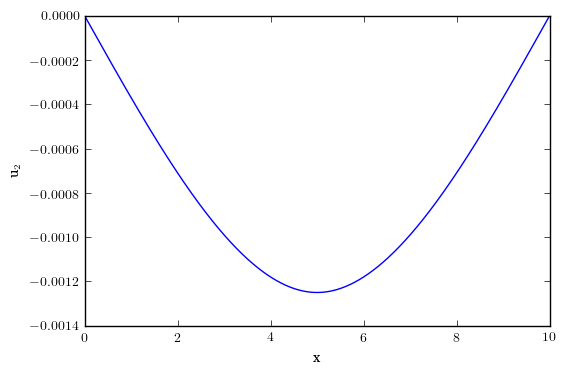

In [4]:
problem = IGABeamFEA(number_of_elements=50, p=4, E=200e9, I=0.1 ** 4. / 12., A=0.1 * 0.0, length=10, 
                     deltaP1=0, deltaP2=100, P1_location=9.9999, P2_location=5, int_rule=5, 
                     constraint_flag=False)
problem.solve(1)
problem.plot_u2(1000)

Deflection at midpoint

In [5]:
problem.evaluate_u2(2)[1][1]

-0.0012499959683663637

Analytic solution

In [6]:
-100 * 10 ** 3 / (48 * 200e9 * 0.1 ** 4. / 12.)

-0.0012499999999999998

## No constraint, no moment of inertia, should reproduce 1D bar

Load Step:1


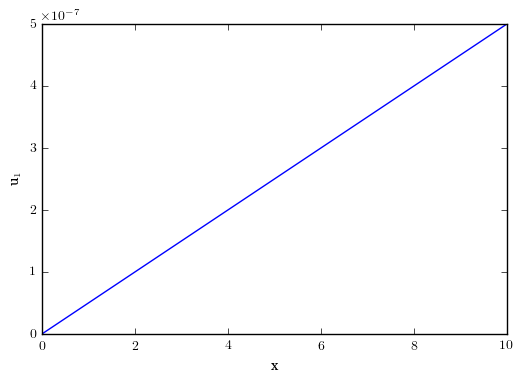

In [7]:
problem = IGABeamFEA(number_of_elements=50, p=4, E=200e9, I=0.0 ** 4. / 12., A=0.1 * 0.1, length=10, 
                     deltaP1=100, deltaP2=0, P1_location=9.9999, P2_location=5, int_rule=5, 
                     constraint_flag=False)
problem.solve(1)
problem.plot_u1(1000)

Displacement at end of bar

In [8]:
problem.evaluate_u1(10000)[1][-1]

4.9994525725131386e-07

Analytic solution

In [9]:
-100 * 10 / (0.1 * 0.1 * 200e9)

-4.999999999999999e-07

## Constrained

Load Step:1


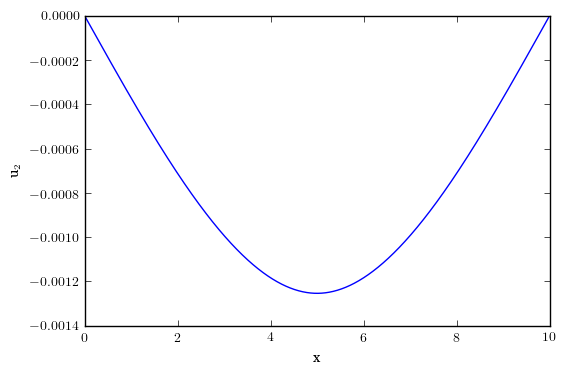

In [10]:
problem = IGABeamFEA(number_of_elements=75, p=5, E=200e9, I=0.1 ** 4. / 12., A=0.1 * 0.1, length=10, 
                     deltaP1=-500, deltaP2=100, P1_location=9.9999, P2_location=5, int_rule=6, 
                     constraint_flag=True)
problem.solve(1)
problem.plot_u2(1000)

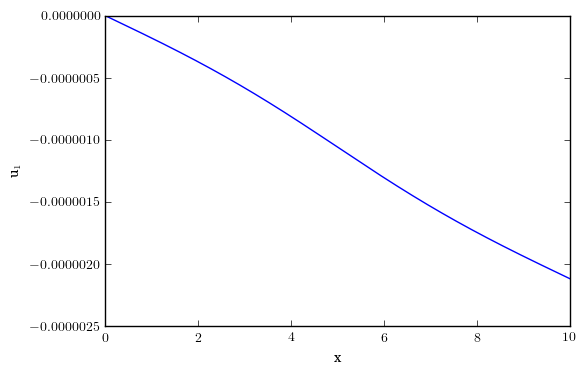

In [11]:
problem.plot_u1(1000)

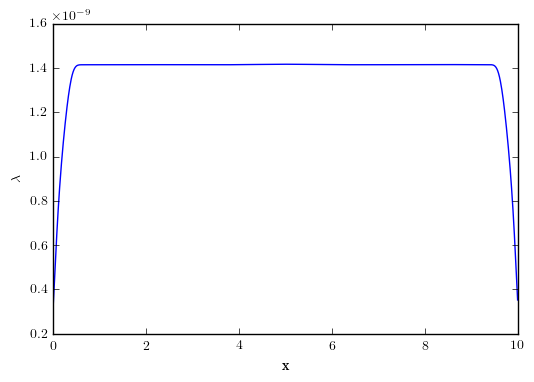

In [12]:
problem.plot_lambda(1000)

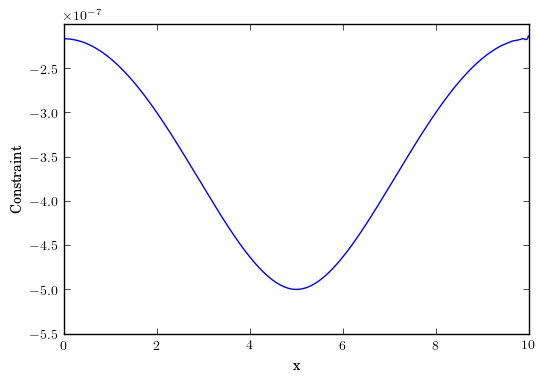

In [13]:
problem.plot_constraint(1000)

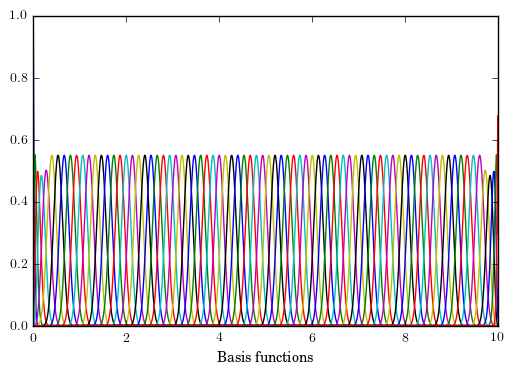

In [14]:
problem.plot_bsplines(1000)

In [21]:
problem = IGAProjectionBeamFEA(number_of_elements=5, p=5, E=200e9, I=0.1 ** 4. / 12., A=0.1 * 0.1, length=10, 
                     deltaP1=10, deltaP2=10, P1_location=9.9999, P2_location=5, int_rule=6, 
                     constraint_flag=True)
problem.solve(1)
problem.plot_u2(1000)

Load Step:1


NoConvergence: [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.52113509e-56
   3.42458011e-42   0.00000000e+00   2.07393527e-56   9.75543355e-42
   0.00000000e+00   3.50411690e-57   1.48653047e-41   0.00000000e+00
   1.93073871e-56   2.91164860e-42   0.00000000e+00   1.93073871e-56
   5.92376740e-42   0.00000000e+00   3.50411690e-57   1.04100857e-41
   0.00000000e+00  -3.61077824e-57   1.13744862e-41   0.00000000e+00
   3.75521206e-56   4.47489414e-42   0.00000000e+00  -8.96884995e-56
   0.00000000e+00   0.00000000e+00]